In [293]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import scipy.stats as sps


sns.set()
pd.set_option("display.precision", 2)

# SCRAPES THE LATEST DATA FROM WORLDOMETERS
url = 'https://www.worldometers.info/coronavirus/#countries'

r = requests.get(url)

c = r.content

soup = bs(c,'html.parser')

foo = soup.findAll('div',{'class' : 'tab-content'})
print (len(foo))

the_div = foo[2]

tbody = the_div.tbody

rows = tbody.findAll('tr')

countries = dict()

for r in rows:
    td = r.findAll('td')
    name = td[0].get_text().strip()
    confirmed = td[1].get_text().strip()
    inc = td[2].get_text().strip()
    deaths = td[3].get_text().strip()
    d_inc = td[4].get_text().strip()
    recovered = td[5].get_text().strip()
    active_cases = td[6].get_text().strip()
    serious = td[7].get_text().strip()
    conf_p_M = td[8].get_text().strip()
    countries[name] = [confirmed,inc,deaths,d_inc,
                       recovered,active_cases,serious,conf_p_M]
    
cols = ['confirmed','inc','dead','dead_inc','recovered',
        'active_cases','serious','confirmed_per_M']

df = pd.DataFrame.from_dict(countries)
df = df.T
df.columns = cols

df[['inc','dead_inc']] = df[['inc','dead_inc']].apply(
    lambda x : x.str.replace('+',''))

df[['confirmed','dead','recovered','active_cases',
    'serious','inc','dead_inc','confirmed_per_M']] = \
    df[['confirmed','dead','recovered','active_cases',
        'serious','inc','dead_inc','confirmed_per_M']].apply(
    lambda x : x.str.replace(',',''))

df[cols] = df[cols].apply(lambda x: x.replace('',np.nan))


df[cols] = df[cols].astype(float)
df['yesterday'] = df['confirmed'] - df['inc']
df['factor'] = df['confirmed'] / df['yesterday']
cols  = ['confirmed', 'yesterday','inc', 'factor','dead', 'dead_inc', 'recovered', 'active_cases',
       'serious', 'confirmed_per_M']

df = df[cols]

#df['factor'].loc[df['factor'] == np.inf]
df['factor'] = df['factor'].replace(np.inf,np.nan)
df['dead_pct'] = 100 * df['dead'] / df['confirmed']
df['dead'] = df['dead'].fillna(0)
df['dead_factor'] = df['dead'].div (df['dead'] - df['dead_inc'])
df['dead_factor'].replace(np.inf,np.nan,inplace=True)

### add population data to calculate dead_per_M

def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

df['dead_per_M'] = df['dead'].div (country_populations['population'] / 1e6)

###

df.head(40)


3


,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M
USA,240395.0,215003.0,25392.0,1.12,5808.0,706.0,10365.0,224222.0,5421.0,726.0,2.42,1.14,17.55
Italy,115242.0,110574.0,4668.0,1.04,13915.0,760.0,18278.0,83049.0,4053.0,1906.0,12.07,1.06,230.15
Spain,110409.0,104118.0,6291.0,1.06,10106.0,719.0,26743.0,73560.0,6092.0,2361.0,9.15,1.08,216.15
Germany,84788.0,77981.0,6807.0,1.09,1107.0,176.0,21400.0,62281.0,3936.0,1012.0,1.31,1.19,13.21
France,59105.0,56989.0,2116.0,1.04,5387.0,1355.0,12428.0,41290.0,6399.0,905.0,9.11,1.34,82.53
Iran,50468.0,47593.0,2875.0,1.06,3160.0,124.0,16711.0,30597.0,3956.0,601.0,6.26,1.04,37.62
UK,33718.0,29474.0,4244.0,1.14,2921.0,569.0,135.0,30662.0,163.0,497.0,8.66,1.24,43.03
Switzerland,18827.0,17768.0,1059.0,1.06,536.0,48.0,4013.0,14278.0,348.0,2175.0,2.85,1.10,61.93
Turkey,18135.0,15679.0,2456.0,1.16,356.0,79.0,415.0,17364.0,1101.0,215.0,1.96,1.29,4.22
Belgium,15348.0,13964.0,1384.0,1.10,1011.0,183.0,2495.0,11842.0,1144.0,1324.0,6.59,1.22,87.23


In [294]:
df.to_pickle('scrape_df.pkl')
df.agg(['sum','max','min','mean','median','count'])


,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M
sum,1.01e+06,928491.00,72597.00,168.32,52611.00,5419.00,210596.0,744586.0,37712.00,76928.5,658.79,98.40,2446.91
max,2.40e+05,215003.00,25392.00,1.87,13915.00,1355.00,76408.0,224222.0,6399.00,8739.0,25.00,3.00,884.15
min,1.00e+00,0.00,1.00,1.00,0.00,1.00,1.0,1.0,1.00,0.1,0.13,1.00,0.00
mean,4.89e+03,6189.94,483.98,1.13,255.39,67.74,1385.5,3614.5,345.98,377.1,4.64,1.26,12.68
median,1.73e+02,341.50,31.00,1.10,3.00,4.00,33.5,140.5,14.00,53.5,2.67,1.17,0.37
count,2.06e+02,150.00,150.00,149.00,206.00,80.00,152.0,206.0,109.00,204.0,142.00,78.00,193.00


In [295]:
today = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')
file_prefix = 'snapshots/corona_snapshot_'
filename = file_prefix + today.replace(' ','_').replace(':','_') + '.pkl'
df['datetime'] = [today] * len(df)
df.set_index([df.index,'datetime'],drop=True).to_pickle(filename)
df.head()

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
USA,240395.0,215003.0,25392.0,1.12,5808.0,706.0,10365.0,224222.0,5421.0,726.0,2.42,1.14,17.55,2020-04-02 22:49:37
Italy,115242.0,110574.0,4668.0,1.04,13915.0,760.0,18278.0,83049.0,4053.0,1906.0,12.07,1.06,230.15,2020-04-02 22:49:37
Spain,110409.0,104118.0,6291.0,1.06,10106.0,719.0,26743.0,73560.0,6092.0,2361.0,9.15,1.08,216.15,2020-04-02 22:49:37
Germany,84788.0,77981.0,6807.0,1.09,1107.0,176.0,21400.0,62281.0,3936.0,1012.0,1.31,1.19,13.21,2020-04-02 22:49:37
France,59105.0,56989.0,2116.0,1.04,5387.0,1355.0,12428.0,41290.0,6399.0,905.0,9.11,1.34,82.53,2020-04-02 22:49:37


In [296]:
import glob
files = [f for f in glob.glob('./' + file_prefix +'*')]

timeline_df = pd.DataFrame()

for f in files:
    temp = pd.read_pickle(f)
    timeline_df = pd.concat([timeline_df,temp],axis=0)
    
timeline_df.sort_index(inplace=True)
timeline_df['dead'] = timeline_df['dead'].fillna(0)
timeline_df

confirmed  yesterday  inc  factor  dead  \
            datetime                                                       
Afghanistan 2020-03-15 15:50:08       16.0       11.0  5.0    1.45   0.0   
            2020-03-15 16:55:44       16.0       11.0  5.0    1.45   0.0   
            2020-03-15 19:43:02       16.0       11.0  5.0    1.45   0.0   
            2020-03-15 21:46:07       16.0       11.0  5.0    1.45   0.0   
            2020-03-15 22:21:09       16.0       11.0  5.0    1.45   0.0   
...                                    ...        ...  ...     ...   ...   
Zimbabwe    2020-04-02 14:52:59        8.0        NaN  NaN     NaN   1.0   
            2020-04-02 19:03:55        8.0        NaN  NaN     NaN   1.0   
            2020-04-02 20:10:41        8.0        NaN  NaN     NaN   1.0   
            2020-04-02 20:52:13        8.0        NaN  NaN     NaN   1.0   
            2020-04-02 22:49:37        9.0        8.0  1.0    1.12   1.0   

                                 dead_inc  recovered  active_cases  serious  \
            datetime                                                          
Afghanistan 2020-03-15 15:50:08       NaN        1.0          15.0      NaN   
            2020-03-15 16:55:44       NaN        1.0          15.0      NaN   
            2020-03-15 19:43:02       NaN        1.0          15.0      NaN   
            2020-03-15 21:46:07       NaN        1.0          15.0      NaN   
            2020-03-15 22:21:09       NaN        1.0          15.0      NaN   
...                                   ...        ...           ...      ...   
Zimbabwe    2020-04-02 14:52:59       NaN        NaN           7.0      NaN   
            2020-04-02 19:03:55       NaN        NaN           7.0      NaN   
            2020-04-02 20:10:41       NaN        NaN           7.0      NaN   
            2020-04-02 20:52:13       NaN        NaN           7.0      NaN   
            2020-04-02 22:49:37       NaN        NaN           8.0      NaN   

                                 confirmed_per_M  dead_pct  dead_factor  \
            datetime                                                      
Afghanistan 2020-03-15 15:50:08              0.4       NaN          NaN   
            2020-03-15 16:55:44              0.4       NaN          NaN   
            2020-03-15 19:43:02              0.4       NaN          NaN   
            2020-03-15 21:46:07              0.4       NaN          NaN   
            2020-03-15 22:21:09              0.4       NaN          NaN   
...                                          ...       ...          ...   
Zimbabwe    2020-04-02 14:52:59              0.5     12.50          NaN   
            2020-04-02 19:03:55              0.5     12.50          NaN   
            2020-04-02 20:10:41              0.5     12.50          NaN   
            2020-04-02 20:52:13              0.5     12.50          NaN   
            2020-04-02 22:49:37              0.6     11.11          NaN   

                                 dead_per_M  
            datetime                         
Afghanistan 2020-03-15 15:50:08         NaN  
            2020-03-15 16:55:44         NaN  
            2020-03-15 19:43:02         NaN  
            2020-03-15 21:46:07         NaN  
            2020-03-15 22:21:09         NaN  
...                                     ...  
Zimbabwe    2020-04-02 14:52:59        0.07  
            2020-04-02 19:03:55        0.07  
            2020-04-02 20:10:41        0.07  
            2020-04-02 20:52:13        0.07  
            2020-04-02 22:49:37        0.07  

[35153 rows x 13 columns]

In [297]:
timeline_group = timeline_df.groupby(level=0)

a_country = timeline_group.get_group('USA')
a_country = timeline_group.get_group('Sweden')
a_country

confirmed  yesterday    inc  factor   dead  \
       datetime                                                          
Sweden 2020-03-15 15:50:08     1024.0      961.0   63.0    1.07    2.0   
       2020-03-15 16:55:44     1024.0      961.0   63.0    1.07    2.0   
       2020-03-15 19:43:02     1024.0      961.0   63.0    1.07    3.0   
       2020-03-15 21:46:07     1040.0      961.0   79.0    1.08    3.0   
       2020-03-15 22:21:09     1040.0      961.0   79.0    1.08    3.0   
...                               ...        ...    ...     ...    ...   
       2020-04-02 14:52:59     5466.0     4947.0  519.0    1.10  282.0   
       2020-04-02 19:03:55     5466.0     4947.0  519.0    1.10  282.0   
       2020-04-02 20:10:41     5466.0     4947.0  519.0    1.10  282.0   
       2020-04-02 20:52:13     5466.0     4947.0  519.0    1.10  282.0   
       2020-04-02 22:49:37     5568.0     4947.0  621.0    1.13  308.0   

                            dead_inc  recovered  active_cases  serious  \
       datetime                                                          
Sweden 2020-03-15 15:50:08       NaN        1.0        1021.0      2.0   
       2020-03-15 16:55:44       NaN        1.0        1021.0      2.0   
       2020-03-15 19:43:02       1.0        1.0        1020.0      2.0   
       2020-03-15 21:46:07       1.0        1.0        1036.0      2.0   
       2020-03-15 22:21:09       1.0        1.0        1036.0      2.0   
...                              ...        ...           ...      ...   
       2020-04-02 14:52:59      43.0      103.0        5081.0    429.0   
       2020-04-02 19:03:55      43.0      103.0        5081.0    429.0   
       2020-04-02 20:10:41      43.0      103.0        5081.0    429.0   
       2020-04-02 20:52:13      43.0      103.0        5081.0    429.0   
       2020-04-02 22:49:37      69.0      103.0        5157.0    429.0   

                            confirmed_per_M  dead_pct  dead_factor  dead_per_M  
       datetime                                                                 
Sweden 2020-03-15 15:50:08            101.4      0.20          NaN         NaN  
       2020-03-15 16:55:44            101.4      0.20          NaN         NaN  
       2020-03-15 19:43:02            101.4      0.29          NaN         NaN  
       2020-03-15 21:46:07            103.0      0.29          NaN         NaN  
       2020-03-15 22:21:09            103.0      0.29          NaN         NaN  
...                                     ...       ...          ...         ...  
       2020-04-02 14:52:59            541.0      5.16         1.18       27.92  
       2020-04-02 19:03:55            541.0      5.16         1.18       27.92  
       2020-04-02 20:10:41            541.0      5.16         1.18       27.92  
       2020-04-02 20:52:13            541.0      5.16         1.18       27.92  
       2020-04-02 22:49:37            551.0      5.53         1.29       30.50  

[190 rows x 13 columns]

In [298]:
non_duplicates = ( ( a_country['confirmed'] != a_country['confirmed'].shift() )  | (
    a_country['dead'] != a_country['dead'].shift()))

a_country = a_country[non_duplicates]
a_country

confirmed  yesterday    inc  factor   dead  \
       datetime                                                          
Sweden 2020-03-15 15:50:08     1024.0      961.0   63.0    1.07    2.0   
       2020-03-15 19:43:02     1024.0      961.0   63.0    1.07    3.0   
       2020-03-15 21:46:07     1040.0      961.0   79.0    1.08    3.0   
       2020-03-16 12:09:38     1043.0     1040.0    3.0    1.00    3.0   
       2020-03-16 13:03:36     1043.0     1040.0    3.0    1.00    6.0   
       2020-03-16 14:09:44     1046.0     1040.0    6.0    1.01    6.0   
       2020-03-16 16:04:29     1103.0     1040.0   63.0    1.06    6.0   
       2020-03-16 16:54:13     1103.0     1040.0   63.0    1.06    7.0   
       2020-03-16 19:48:19     1119.0     1040.0   79.0    1.08    7.0   
       2020-03-16 22:22:56     1121.0     1040.0   81.0    1.08    7.0   
       2020-03-17 13:58:53     1125.0     1121.0    4.0    1.00    7.0   
       2020-03-17 15:16:49     1175.0     1121.0   54.0    1.05    7.0   
       2020-03-17 16:41:28     1190.0     1121.0   69.0    1.06    7.0   
       2020-03-17 17:36:32     1191.0     1121.0   70.0    1.06    8.0   
       2020-03-17 23:06:02     1196.0     1121.0   75.0    1.07    8.0   
       2020-03-18 16:05:48     1292.0     1196.0   96.0    1.08    8.0   
       2020-03-18 18:51:01     1292.0     1196.0   96.0    1.08   10.0   
       2020-03-19 10:03:05     1301.0        NaN    NaN     NaN   10.0   
       2020-03-19 12:00:54     1302.0     1301.0    1.0    1.00   10.0   
       2020-03-19 13:35:24     1331.0     1301.0   30.0    1.02   10.0   
       2020-03-19 15:35:27     1439.0     1301.0  138.0    1.11   11.0   
       2020-03-20 10:52:14     1452.0     1439.0   13.0    1.01   11.0   
       2020-03-20 12:29:59     1456.0     1439.0   17.0    1.01   11.0   
       2020-03-20 15:26:23     1639.0     1439.0  200.0    1.14   16.0   
       2020-03-21 18:21:32     1764.0     1639.0  125.0    1.08   20.0   
       2020-03-22 14:07:53     1867.0     1770.0   97.0    1.05   21.0   
       2020-03-22 16:21:10     1906.0     1770.0  136.0    1.08   21.0   
       2020-03-23 07:46:57     1934.0        NaN    NaN     NaN   21.0   
       2020-03-23 13:00:49     1934.0        NaN    NaN     NaN   25.0   
       2020-03-23 19:03:33     2046.0     1934.0  112.0    1.06   25.0   
       2020-03-24 09:31:25     2059.0     2046.0   13.0    1.01   33.0   
       2020-03-24 16:01:28     2286.0     2046.0  240.0    1.12   36.0   
       2020-03-25 07:51:01     2299.0        NaN    NaN     NaN   40.0   
       2020-03-25 10:03:02     2300.0     2299.0    1.0    1.00   40.0   
       2020-03-25 15:02:47     2526.0     2299.0  227.0    1.10   42.0   
       2020-03-25 16:22:21     2526.0     2299.0  227.0    1.10   44.0   
       2020-03-25 21:48:40     2526.0     2299.0  227.0    1.10   62.0   
       2020-03-26 15:38:54     2840.0     2526.0  314.0    1.12   70.0   
       2020-03-26 17:27:13     2840.0     2526.0  314.0    1.12   71.0   
       2020-03-26 23:33:28     2840.0     2526.0  314.0    1.12   77.0   
       2020-03-27 12:33:35     2858.0     2840.0   18.0    1.01   77.0   
       2020-03-27 13:07:38     2893.0     2840.0   53.0    1.02   77.0   
       2020-03-27 15:39:37     3046.0     2840.0  206.0    1.07   92.0   
       2020-03-27 22:10:14     3069.0     2840.0  229.0    1.08   92.0   
       2020-03-27 23:32:12     3069.0     2840.0  229.0    1.08  105.0   
       2020-03-28 18:35:59     3447.0     3069.0  378.0    1.12  105.0   
       2020-03-29 14:57:52     3700.0     3447.0  253.0    1.07  110.0   
       2020-03-30 14:32:14     4028.0     3700.0  328.0    1.09  146.0   
       2020-03-31 18:38:53     4435.0     4028.0  407.0    1.10  180.0   
       2020-04-01 17:15:07     4947.0     4435.0  512.0    1.12  239.0   
       2020-04-02 14:52:59     5466.0     4947.0  519.0    1.10  282.0   
       2020-04-02 22:49:37     5568.0     4947.0  621.0    1.13  308.0   

                            dea

In [299]:
resample = a_country.droplevel(0)
resample.index = pd.DatetimeIndex(resample.index)
#resample = resample.resample('180T').bfill()
resample = resample.resample('D').bfill()

index = pd.to_datetime(resample.index)

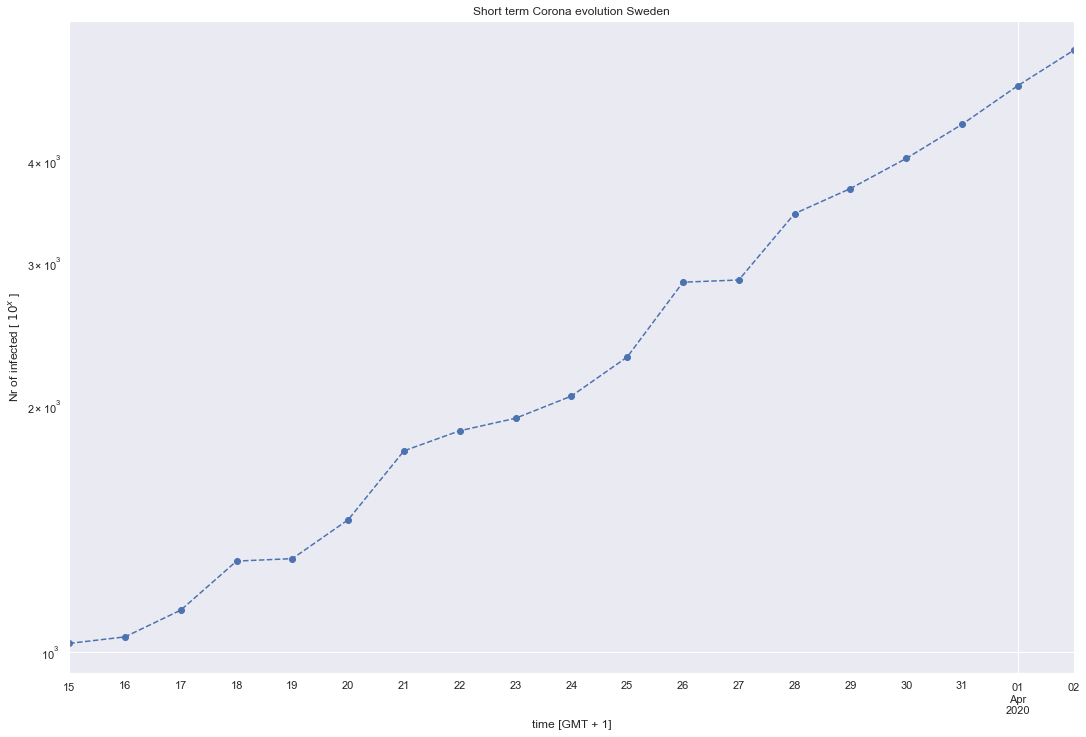

In [300]:


plt.figure(figsize=(18,12))
plt.title('Short term Corona evolution {}'.format(a_country.index[0][0]))
resample['confirmed'].plot(style ='o--')
#plt.xticks(rotation=90)
#plt.xticks(np.arange(len(index)),index.values)
plt.xlabel('time [GMT + 1]')

#plt.ylabel('Nr of infected')
plt.ylabel(r'Nr of infected [ $10^{x}$ ]')
plt.yscale('log')

filename = 'corona_short_term_' + a_country.index[0][0] + '.jpg'
plt.savefig (filename,format='jpg')


In [301]:
top_dead_pct = df.loc[df['confirmed'] > 500].sort_values('dead_pct',ascending=False)
top_dead_pct

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
Italy,115242.0,110574.0,4668.0,1.04,13915.0,760.0,18278.0,83049.0,4053.0,1906.0,12.07,1.06,230.15,2020-04-02 22:49:37
Indonesia,1790.0,1677.0,113.0,1.07,170.0,13.0,112.0,1508.0,NaN,7.0,9.50,1.08,0.62,2020-04-02 22:49:37
Spain,110409.0,104118.0,6291.0,1.06,10106.0,719.0,26743.0,73560.0,6092.0,2361.0,9.15,1.08,216.15,2020-04-02 22:49:37
France,59105.0,56989.0,2116.0,1.04,5387.0,1355.0,12428.0,41290.0,6399.0,905.0,9.11,1.34,82.53,2020-04-02 22:49:37
Netherlands,14697.0,13614.0,1083.0,1.08,1339.0,166.0,250.0,13108.0,1053.0,858.0,9.11,1.14,78.14,2020-04-02 22:49:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Singapore,1049.0,1000.0,49.0,1.05,4.0,1.0,266.0,779.0,24.0,179.0,0.38,1.33,0.68,2020-04-02 22:49:37
South Africa,1462.0,1380.0,82.0,1.06,5.0,NaN,50.0,1407.0,7.0,25.0,0.34,NaN,0.08,2020-04-02 22:49:37
Qatar,949.0,835.0,114.0,1.14,3.0,1.0,72.0,874.0,37.0,329.0,0.32,1.50,1.04,2020-04-02 22:49:37
Iceland,1319.0,1220.0,99.0,1.08,4.0,2.0,284.0,1031.0,12.0,3865.0,0.30,2.00,11.72,2020-04-02 22:49:37


In [302]:
country_names = sorted(df.index.values)
#country_names

In [303]:
df.loc[df['confirmed'] > 500 ].sort_values('factor',ascending=False)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
Russia,3548.0,2777.0,771.0,1.28,30.0,6.0,235.0,3283.0,8.0,24.0,0.85,1.25,0.21,2020-04-02 22:49:37
India,2536.0,1998.0,538.0,1.27,72.0,14.0,189.0,2275.0,NaN,2.0,2.84,1.24,0.05,2020-04-02 22:49:37
UAE,1024.0,814.0,210.0,1.26,8.0,NaN,96.0,920.0,2.0,104.0,0.78,NaN,NaN,2020-04-02 22:49:37
Moldova,505.0,423.0,82.0,1.19,6.0,1.0,23.0,476.0,65.0,125.0,1.19,1.20,1.49,2020-04-02 22:49:37
Algeria,986.0,847.0,139.0,1.16,86.0,28.0,61.0,839.0,NaN,22.0,8.72,1.48,1.96,2020-04-02 22:49:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
China,81589.0,81554.0,35.0,1.00,3318.0,6.0,76408.0,1863.0,429.0,57.0,4.07,1.00,2.31,2020-04-02 22:49:37
Japan,2384.0,NaN,NaN,NaN,57.0,NaN,472.0,1855.0,69.0,19.0,2.39,NaN,0.45,2020-04-02 22:49:37
Panama,1317.0,NaN,NaN,NaN,32.0,NaN,9.0,1276.0,50.0,305.0,2.43,NaN,7.42,2020-04-02 22:49:37
Argentina,1133.0,NaN,NaN,NaN,34.0,2.0,256.0,843.0,NaN,25.0,3.00,1.06,0.75,2020-04-02 22:49:37


In [304]:
top_10_per_m = df.sort_values('dead_per_M',ascending=False).head(10)
top_10_per_m

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
San Marino,245.0,236.0,9.0,1.04,30.0,2.0,21.0,194.0,15.0,7221.0,12.24,1.07,884.15,2020-04-02 22:49:37
Italy,115242.0,110574.0,4668.0,1.04,13915.0,760.0,18278.0,83049.0,4053.0,1906.0,12.07,1.06,230.15,2020-04-02 22:49:37
Spain,110409.0,104118.0,6291.0,1.06,10106.0,719.0,26743.0,73560.0,6092.0,2361.0,9.15,1.08,216.15,2020-04-02 22:49:37
Andorra,428.0,390.0,38.0,1.10,15.0,1.0,10.0,403.0,12.0,5539.0,3.50,1.07,194.14,2020-04-02 22:49:37
Belgium,15348.0,13964.0,1384.0,1.10,1011.0,183.0,2495.0,11842.0,1144.0,1324.0,6.59,1.22,87.23,2020-04-02 22:49:37
France,59105.0,56989.0,2116.0,1.04,5387.0,1355.0,12428.0,41290.0,6399.0,905.0,9.11,1.34,82.53,2020-04-02 22:49:37
Netherlands,14697.0,13614.0,1083.0,1.08,1339.0,166.0,250.0,13108.0,1053.0,858.0,9.11,1.14,78.14,2020-04-02 22:49:37
Switzerland,18827.0,17768.0,1059.0,1.06,536.0,48.0,4013.0,14278.0,348.0,2175.0,2.85,1.10,61.93,2020-04-02 22:49:37
Luxembourg,2487.0,2319.0,168.0,1.07,30.0,1.0,80.0,2377.0,31.0,3973.0,1.21,1.03,47.93,2020-04-02 22:49:37
UK,33718.0,29474.0,4244.0,1.14,2921.0,569.0,135.0,30662.0,163.0,497.0,8.66,1.24,43.03,2020-04-02 22:49:37


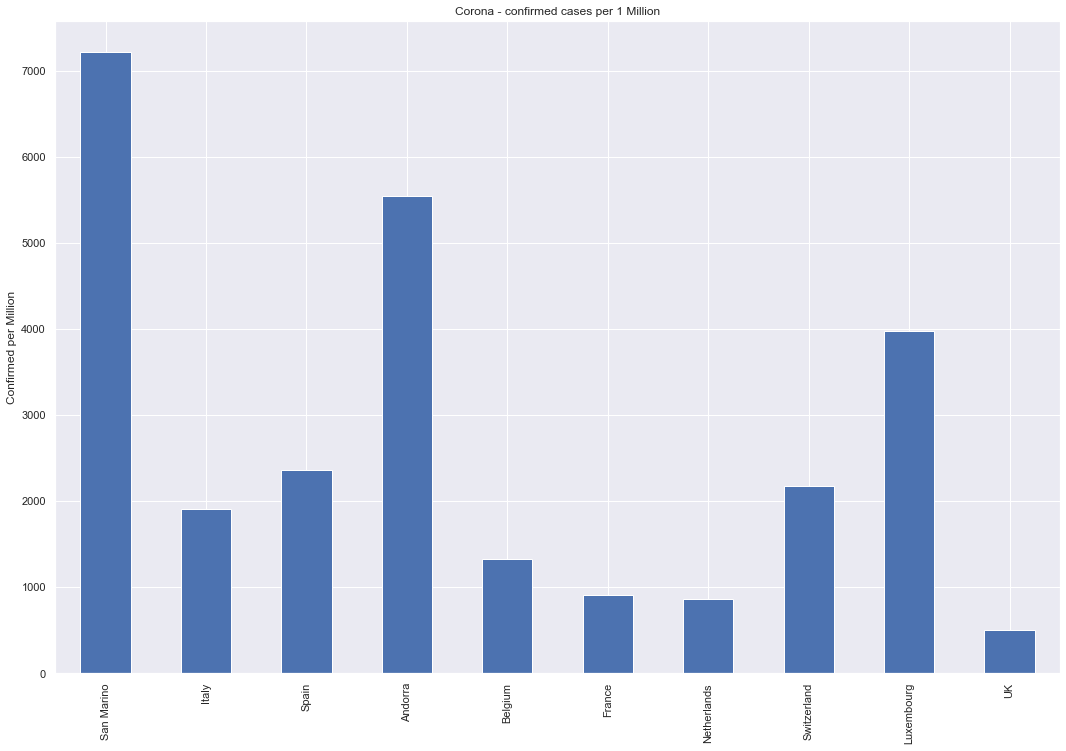

In [305]:
plt.figure(figsize=(18,12))
plt.title('Corona - confirmed cases per 1 Million')
plt.ylabel ('Confirmed per Million')
top_10_per_m['confirmed_per_M'].plot(kind='bar')
plt.savefig('confirmed_per_million.jpg',format='jpg')

In [306]:
totals = pd.DataFrame(df.sum(),columns=['totals'])
totals.drop(['factor','confirmed_per_M','dead_pct','datetime'],inplace=True)
totals

,totals
confirmed,1e+06
yesterday,9.3e+05
inc,7.3e+04
dead,5.3e+04
dead_inc,5.4e+03
recovered,2.1e+05
active_cases,7.4e+05
serious,3.8e+04
dead_factor,98
dead_per_M,2.4e+03


In [307]:
country_names = list(sorted((df.index.unique().values)))
country_names

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'CAR',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Caribbean Netherlands',
 'Cayman Islands',
 'Chad',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'DRC',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Faeroe Islands',
 'Fiji',
 'Finland',
 'France',
 'French Guiana',
 'French Polynesia',
 'Gabon',
 'Gambia',
 

In [308]:
some_countries = ['Sweden','Finland','Denmark','Norway','Iceland']
countries_of_interest = df.loc[some_countries,:]
countries_of_interest.sort_values('dead_per_M',inplace=True,ascending=False)
countries_of_interest

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
Sweden,5568.0,4947.0,621.0,1.13,308.0,69.0,103.0,5157.0,429.0,551.0,5.53,1.29,30.50,2020-04-02 22:49:37
Denmark,3386.0,3107.0,279.0,1.09,123.0,19.0,1089.0,2174.0,153.0,585.0,3.63,1.18,21.24,2020-04-02 22:49:37
Iceland,1319.0,1220.0,99.0,1.08,4.0,2.0,284.0,1031.0,12.0,3865.0,0.30,2.00,11.72,2020-04-02 22:49:37
Norway,5142.0,4877.0,265.0,1.05,50.0,6.0,32.0,5060.0,96.0,948.0,0.97,1.14,9.22,2020-04-02 22:49:37
Finland,1518.0,1446.0,72.0,1.05,19.0,2.0,300.0,1199.0,65.0,274.0,1.25,1.12,3.43,2020-04-02 22:49:37


In [309]:
countries_of_interest.sort_values('confirmed_per_M',ascending=False)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
Iceland,1319.0,1220.0,99.0,1.08,4.0,2.0,284.0,1031.0,12.0,3865.0,0.30,2.00,11.72,2020-04-02 22:49:37
Norway,5142.0,4877.0,265.0,1.05,50.0,6.0,32.0,5060.0,96.0,948.0,0.97,1.14,9.22,2020-04-02 22:49:37
Denmark,3386.0,3107.0,279.0,1.09,123.0,19.0,1089.0,2174.0,153.0,585.0,3.63,1.18,21.24,2020-04-02 22:49:37
Sweden,5568.0,4947.0,621.0,1.13,308.0,69.0,103.0,5157.0,429.0,551.0,5.53,1.29,30.50,2020-04-02 22:49:37
Finland,1518.0,1446.0,72.0,1.05,19.0,2.0,300.0,1199.0,65.0,274.0,1.25,1.12,3.43,2020-04-02 22:49:37


In [310]:
european_countries = pd.read_csv('european_countries.csv',sep=';',
                     encoding='ISO-8859-1',header=None,
                     names=['country','population','region'],
                    thousands=',')
europe_names = list(european_countries['country'].values)

try:
    europe = df.loc[europe_names,:]
except KeyError:
    print ('some country from european_countries missing from dataset')
    
europe.sort_values('confirmed',ascending=False,inplace=True)
europe

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
Italy,115242.0,110574.0,4668.0,1.04,13915.0,760.0,18278.0,83049.0,4053.0,1906.0,12.07,1.06,230.15,2020-04-02 22:49:37
Spain,110409.0,104118.0,6291.0,1.06,10106.0,719.0,26743.0,73560.0,6092.0,2361.0,9.15,1.08,216.15,2020-04-02 22:49:37
Germany,84788.0,77981.0,6807.0,1.09,1107.0,176.0,21400.0,62281.0,3936.0,1012.0,1.31,1.19,13.21,2020-04-02 22:49:37
France,59105.0,56989.0,2116.0,1.04,5387.0,1355.0,12428.0,41290.0,6399.0,905.0,9.11,1.34,82.53,2020-04-02 22:49:37
UK,33718.0,29474.0,4244.0,1.14,2921.0,569.0,135.0,30662.0,163.0,497.0,8.66,1.24,43.03,2020-04-02 22:49:37
Switzerland,18827.0,17768.0,1059.0,1.06,536.0,48.0,4013.0,14278.0,348.0,2175.0,2.85,1.10,61.93,2020-04-02 22:49:37
Belgium,15348.0,13964.0,1384.0,1.10,1011.0,183.0,2495.0,11842.0,1144.0,1324.0,6.59,1.22,87.23,2020-04-02 22:49:37
Netherlands,14697.0,13614.0,1083.0,1.08,1339.0,166.0,250.0,13108.0,1053.0,858.0,9.11,1.14,78.14,2020-04-02 22:49:37
Austria,11123.0,10711.0,412.0,1.04,158.0,12.0,1749.0,9216.0,227.0,1235.0,1.42,1.08,17.54,2020-04-02 22:49:37
Portugal,9034.0,8251.0,783.0,1.09,209.0,22.0,68.0,8757.0,230.0,886.0,2.31,1.12,20.50,2020-04-02 22:49:37


In [311]:
europe_sum = europe[['confirmed','yesterday','inc','dead','dead_inc','recovered','active_cases']].sum()
europe_sum

confirmed       520707.0
yesterday       487141.0
inc              33566.0
dead             37850.0
dead_inc          4198.0
recovered        90727.0
active_cases    392130.0
dtype: float64

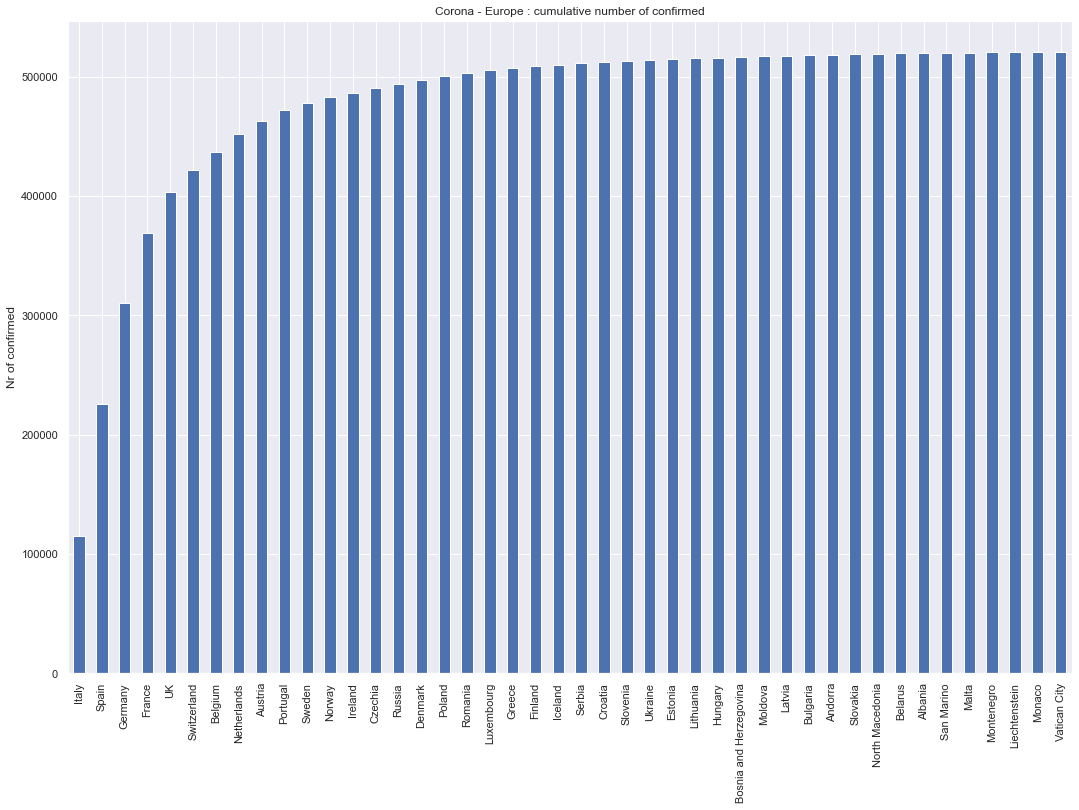

In [312]:
plt.figure(figsize=(18,12))
europe['confirmed'].cumsum().plot(kind='bar')
plt.title('Corona - Europe : cumulative number of confirmed')
plt.ylabel('Nr of confirmed')
plt.savefig('Corona_europe_cumulative.jpg',format='jpg')


In [313]:
def standardize(x):
    return (x - x.mean()) / x.std()

min_confirmed = 100
max_confirmed = 100000 # exclude e.g. China for better view

df_no_extrems = df.loc[ ( ( df['confirmed'] > min_confirmed  ) & ( df['confirmed'] < max_confirmed )) ]
df_no_extrems = df_no_extrems.loc[df_no_extrems['factor'] > 0]
df_no_extrems = df_no_extrems.loc[( 
    ( df_no_extrems['confirmed'] >= min_confirmed ) & (df_no_extrems['confirmed'] <= max_confirmed))]

x = df_no_extrems['confirmed_per_M']
x = standardize(x)
y = df_no_extrems['factor']
y = standardize(y)

In [314]:
# 

slope,intercept,_,_,_ = sps.linregress(x,y)

alpha_mu = 0
alpha_sigma = 1
beta_mu = 0
beta_sigma = 1


alpha = pm.Normal('alpha',mu=alpha_mu,tau = 1 / alpha_sigma ** 2)
beta = pm.Normal('beta',mu=beta_mu,tau = 1 / beta_sigma ** 2)

# by changing sigma from uniform to lognormal, the y-range of sample plot below
# shrunk a lot

sigma = pm.Uniform('sigma',lower=0,upper=10)

@pm.deterministic()
def linreq_mu(x=x,beta=beta,alpha=alpha):
    return x * beta + alpha

likelihood  = pm.Normal('likelihood',mu=linreq_mu,tau= 1 / sigma ** 2,
                       observed=True,value=y)

model = pm.Model([alpha,beta,sigma,linreq_mu,likelihood])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

mcmc.sample(10000,5000,2)

alpha_samples = mcmc.trace('alpha')[:]
beta_samples = mcmc.trace('beta')[:]
sigma_samples = mcmc.trace('sigma')[:]
linreq_mu_samples = mcmc.trace('sigma')[:]

result = pd.DataFrame({'alpha_post': alpha_samples,
                     'beta_post' : beta_samples,
                     'sigma_post' : sigma_samples,
                     'linreq_mu_post' : linreq_mu_samples})


 [-----------------100%-----------------] 10000 of 10000 complete in 13.1 sec

,alpha_post,beta_post,sigma_post,linreq_mu_post
count,2.50e+03,2500.00,2500.00,2500.00
mean,5.37e-07,-0.13,1.00,1.00
std,2.18e-06,0.10,0.07,0.07
min,-8.44e-06,-0.48,0.82,0.82
25%,-1.70e-08,-0.20,0.96,0.96
50%,-9.64e-11,-0.13,1.00,1.00
75%,7.58e-08,-0.07,1.05,1.05
max,1.44e-05,0.19,1.23,1.23


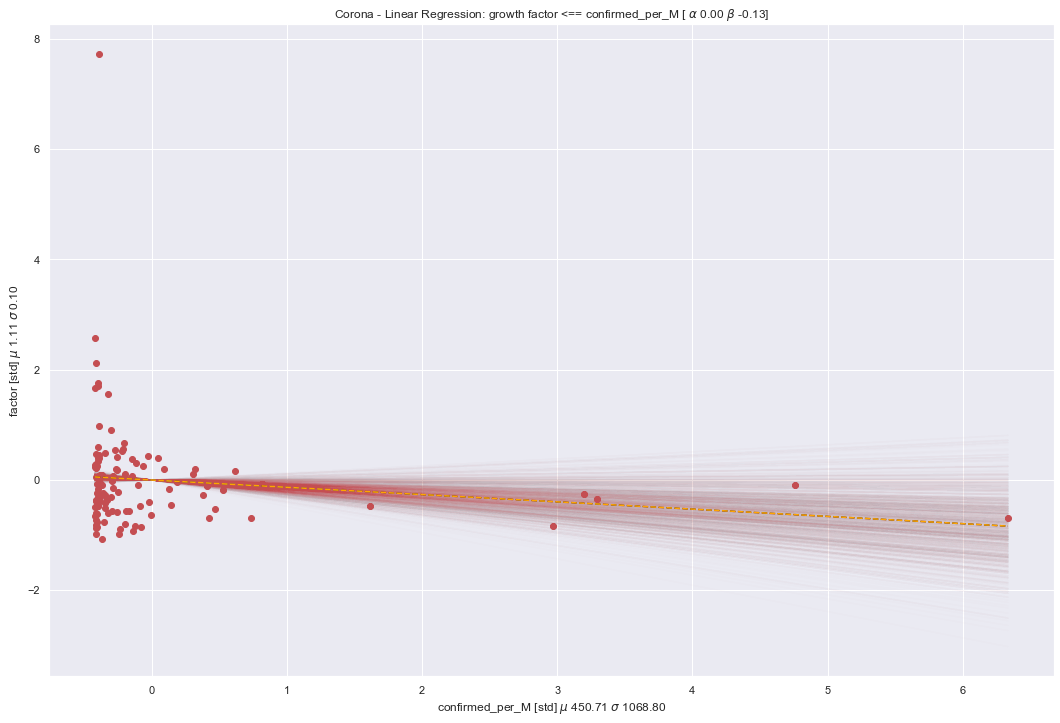

In [315]:

nr_rows = 100
nr_samples = 1000

alphas = np.random.choice(result['alpha_post'],replace=True,size=nr_samples)
betas = np.random.choice(result['beta_post'],replace=True,size=nr_samples)

X = np.linspace(x.min(),x.max(),nr_rows)

line_ys = np.array([X[i] * betas + alphas for i in range(len(X))])

plt.figure(figsize=(18,12))

line_alpha = result['alpha_post'].mean()
line_beta = result['beta_post'].mean()

plt.title(r'Corona - Linear Regression: growth factor <== confirmed_per_M [ $\alpha$ {:.2f} $\beta$ {:.2f}]'.format(
                                                                                        line_alpha,line_beta))

plt.ylabel(r'factor [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(df_no_extrems['factor'].mean(),
                                                              df_no_extrems['factor'].std()))
plt.xlabel(r'confirmed_per_M [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(df_no_extrems['confirmed_per_M'].mean(),
                                                             df_no_extrems['confirmed_per_M'].std()))
plt.scatter(x,y,color='r')
plt.plot(X,[X[i] * slope + intercept for i in range(len(X))],color='k',ls='dashed')
plt.plot(X,line_ys,color='r',alpha = 0.01)
plt.plot(X,[X[i] * result['beta_post'].mean() + result['alpha_post'].mean() for i in range(len(X))],
        color='orange',ls='dashed')
result.describe()


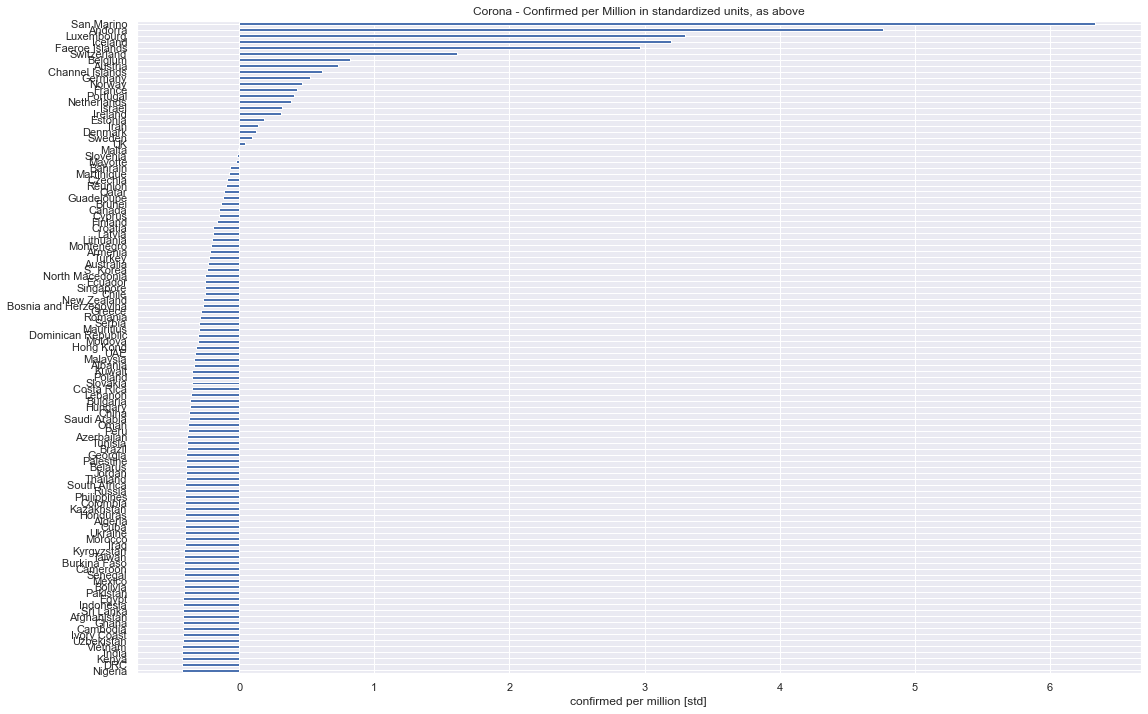

In [316]:
plt.figure(figsize=(18,12))
plt.title ('Corona - Confirmed per Million in standardized units, as above')
plt.xlabel('confirmed per million [std]')
#df_no_extrems['confirmed_per_M'].sort_values().plot(kind='barh')
std_values = standardize(df_no_extrems['confirmed_per_M'])
_= std_values.sort_values().plot(kind='barh')

